# Disclaimer

This is my attempt to test the effectiveness of Progressive Resizing, TTA and Mixup for Image Classification.

Course source from [Ch 7. Training a State-of-the-Art Model](https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb).

Dataset from [Lance Zhang](https://www.kaggle.com/lantian773030/pokemonclassification).

~ Melisa Surja

# Installing Dependencies

In [1]:
# !pip install -Uqq fastbook
# !pip install kaggle
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.callback.fp16 import *

# Downloading Dataset

We're going to use [Pokemon Dataset from Kaggle](https://www.kaggle.com/lantian773030/pokemonclassification).

You need an API key to use the Kaggle API. 

How to get one: 
1. Register an account from Kaggle
1. Click on your profile picture on the Kaggle website, and choose Account
1. Click Create New API Token. This will save a file called `kaggle.json` to your PC. 
1. Put the `kaggle.json` file in `~/root/.kaggle/` folder

In [3]:
from kaggle import api
path = Path('Pokemon')
Path.BASE_PATH = path
path

Path('.')

Pro-tip: use the command `api.dataset_list(search='pokemon')` to get the dataset's reference name, `lantian773030/pokemonclassification`.

In [4]:
if not path.exists():
  path.mkdir(parents=true)
  api.dataset_download_files('lantian773030/pokemonclassification', path=path, unzip=true)
path.ls()

(#1) [Path('PokemonData')]

# Prepare Dataset

The dataset contains `.svg` and other image file types that might cause errors, so let's limit our image files to `.jpg` and `.jpeg` files only.

I'm also not applying Normalization because we're not using a pre-trained model.

### Data Augmentation

I'm adding `mult=1.5` to amplify batch transformation effects. Don't pick a number that's too big because it might distort your images too much.

In [5]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=partial(get_files, extensions=['.jpg','.jpeg']),
                   get_y=parent_label,
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=size, min_scale=0.75, mult=1.5))
    return dblock.dataloaders(path/'PokemonData', bs=bs, num_workers=0) #num_workers=0 for windows.

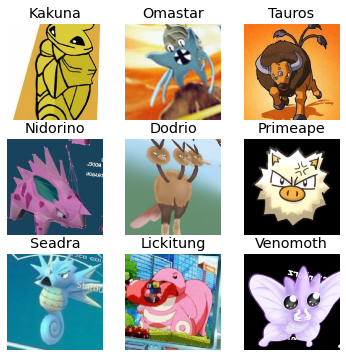

In [6]:
# Tried bs=512, the model was less accurate overall and didn't improve training speedd at all.
# Size 32 or 64 didn't reduce learning time at all, they're all around 1:03
dls = get_dls(16, 96)
dls.train.show_batch(figsize=(6,6))

Let's view our data augmentation results. If the transformation results are too extreme, it can be reduced by reducing `mult` variable from DataBlock API.

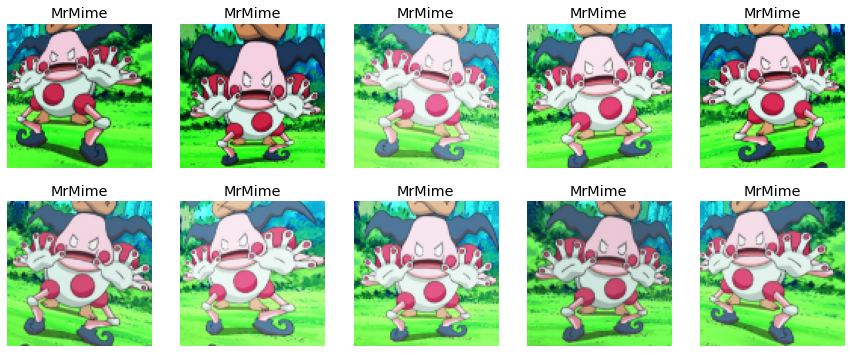

In [7]:
dls.train.show_batch(max_n=10, nrows=2, unique=True)

In [8]:
# Not using cnn_learner because accuracy is super low. Less than half of the other learner...
# learn = cnn_learner(dls, resnet50, pretrained=False, metrics=accuracy) 

# Not using loss_func=CrossEntropyLossFlat() because the accuracy is lower somehow?
learn = Learner(dls, xresnet18(n_out=dls.c), metrics=accuracy).to_fp16()

(0.33113112449646, 2.7542285919189453)

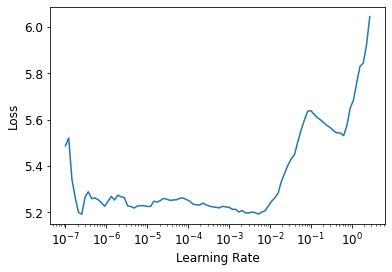

In [9]:
lr_min,lr_steep = learn.lr_find()
lr_min,lr_steep

In [10]:
learn.fit_one_cycle(20, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,4.995642,4.913433,0.027633,01:23
1,4.410015,4.357766,0.075429,01:19
2,3.804894,3.711401,0.142644,01:18
3,3.307892,3.269942,0.209858,01:18
4,2.875290,2.736160,0.310680,01:19
5,2.436306,2.211773,0.433906,01:19
6,2.161867,1.870661,0.508588,01:18
7,1.852699,1.743209,0.539208,01:17
8,1.557187,1.436856,0.587005,01:17
9,1.391818,1.267028,0.660941,01:17


# Using MixUp

Let's make a second learner that uses MixUp to train.

Pay attention that the learning rate for non-mixup and with-mixup learner are similar. MixUp takes 2-3 seconds longer to train.

In [17]:
learn2 = Learner(dls, xresnet18(n_out=dls.c), metrics=accuracy, cbs=MixUp())

(0.0007585775572806596, 6.918309736647643e-06)

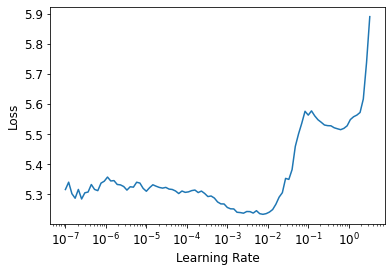

In [15]:
lr_min2,lr_steep2 = learn2.lr_find()
lr_min2,lr_steep2

In [ ]:
learn2.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.795760,4.699226,0.034354,01:18
1,4.170461,3.985153,0.098581,01:19
2,3.801890,3.596362,0.167289,01:19
3,3.545750,3.198792,0.229276,01:19
4,3.175873,2.691552,0.316654,01:19
5,2.659697,2.198581,0.433906,01:20
6,2.379905,1.909644,0.481703,01:19
7,2.152043,1.605104,0.573562,01:20
8,1.878542,1.516434,0.592980,01:19
9,1.737381,1.325586,0.631815,01:20


As you can see, mixup's improvement only starts showing after epoch #15. 

In the end, after 20 epochs mixup is about 1.4% more accurate.

## Fine tuning with bigger images

Bigger images (size=224) take about 01:33 = 93 seconds to train for one epoch.

Smaller images (size=96) take about 01:33 = 93 seconds to train for one epoch. It is 22% faster to train with smaller images first.

Because the result of the mixup's model is better, let's fine tune `learn2`.

In [ ]:
learn2.dls = get_dls(64, 224)
learn2.fine_tune(10, 1e-3)

# Using TTA

TTA improves accuracy by about 1.2% percent.

In [ ]:
preds,targs = learn2.tta()
accuracy(preds, targs).item()

Let's test our model!

In [ ]:
learn2.show_results()

# Exporting the model

In [ ]:
export_file_name = 'export2.pkl'
learn2.export(fname=export_file_name) # export into export.pkl